# Introduction to probabilistic graphical models

**Sources:** 
1. Christopher Bishop's book [Pattern recognition and machine learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)
2. Philipp Hennig's [course on Probabilistic ML](https://uni-tuebingen.de/en/180804)
3. The [course on probabilistic graphical models](https://ermongroup.github.io/cs228-notes/) by Stefano Ermon's group
3. The python library [`pgmpy`](https://pgmpy.org)

## Bayesian inference

1. Construct a joint distribution $p(X,Y)$ over the data $(X,Y)$.
2. Condition on the observed variable $X$ to compute the posterior distribution

$$p(Y|X)= \frac{p(X,Y)}{p(X)}= \frac{p(X|Y)p(Y)}{ \int p(X|y)p(y) \mathrm{d}y}.$$

3. Query the posterior distribution $p(Y|x)$ to predict the distribution of values $Y$ for a new data point $x$.

**Problem:** Naive Bayesian inference is often intractable if the range of $(X,Y)$ is "too large".

$\Rightarrow$ *(Probabilistic) graphical models (PGMs)* leverage conditional independencies to compactly represent joint distributions and efficiently perform inference.

We will look at the following models:
1. *Bayes(ian)/belief models/networks* (directed graphs)
2. *Markov models/networks / Markov random fields* (undirected graphs)

## Bayesian models

* Use a directed acyclic graph (DAG) to represent a set of random variables and their conditional dependencies.
* A node $N$ in the graph represents the conditional distribution $p(N | \mathrm{Pa}(N))$, where $\mathrm{Pa}(N)$ is the set of parents of $N$.
* Joint distribution is given by:

$$p(N_1,\dots,N_K) = \prod_{i=1}^K p(N_i | \mathrm{Pa}(N_i))$$

$\Rightarrow$ Assuming each variable $N_i$ has $n$ outcomes and $k \ll K$ parents, this reduces the number of values from $n^K$ to $K n^{k+1}$.

### Example: Student model

Describes the intelligence of a student (average/high), his score in the SAT exam (bad/good), the grade he gets in the class (A,B,C), the difficulty of the class (easy/hard), and the quality of the recommendation letter he gets from the professor after completing the course (bad/good).

Notation:
1. Gray nodes are called *observed variables*, which we expect to obtain for new data points.
2. White nodes are *hidden variables / latent variables*, some of which we are interested in estimating.

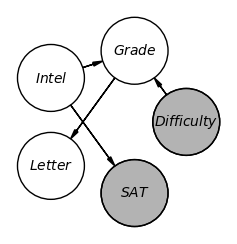

In [1]:
import utils

model = utils.student_model()
utils.render(model)

Let us look at the conditional distributions.

In [2]:
node = "Grade" # try "Intel"
utils.print_cpd(model.get_cpds(node))

+------------+------------------+------------------+------------------+------------------+
| Intel      | Intel(Average)   | Intel(Average)   | Intel(High)      | Intel(High)      |
+------------+------------------+------------------+------------------+------------------+
| Difficulty | Difficulty(Easy) | Difficulty(Hard) | Difficulty(Easy) | Difficulty(Hard) |
+------------+------------------+------------------+------------------+------------------+
| Grade(A)   | 0.3              | 0.05             | 0.9              | 0.5              |
+------------+------------------+------------------+------------------+------------------+
| Grade(B)   | 0.4              | 0.25             | 0.08             | 0.3              |
+------------+------------------+------------------+------------------+------------------+
| Grade(C)   | 0.3              | 0.7              | 0.02             | 0.2              |
+------------+------------------+------------------+------------------+------------------+

### Joint distribution

The structure leads to a reduced representation of the joint distribution (see [chain rule of probability](https://en.wikipedia.org/wiki/Chain_rule_(probability)))

$$ P(L,G,D,I,S) = \underbrace{P(L|G,D,I,S)}_{P(L|G)} \ \underbrace{P(G|D,I,S)}_{P(G|D,I)} \ \underbrace{P(S|D,I)}_{P(S|I)} \ \underbrace{P(D|I)\ }_{P(D)} P(I), $$

which reduces the number of values from $48$ to $26$.

In [3]:
from itertools import product

utils.print_cpds(model)
print("---")
print(f"Joint: {len(list(product(*model.states.values())))} values")
print(f"PGM: {sum(cpd.values.size for cpd in model.cpds)} values")

P(Difficulty), 2 values
P(Intel), 2 values
P(Grade|Intel, Difficulty), 12 values
P(Letter|Grade), 6 values
P(SAT|Intel), 4 values
---
Joint: 48 values
PGM: 26 values


### Inference

The structure helps in marginalization, as we can break the computation into smaller parts (*variable eliminiation*). For instance:

\begin{align*}
P(G) = \sum_{L,D,I,S} P(L,G,D,I,S) &= \sum_{L,D,I,S} P(L|G) P(G|D,I) P(S|I) P(D) P(I) \\&= \sum_{D} P(D) \sum_{I} P(G|D,I)P(I) \sum_{S}   P(S|I) \sum_{L} P(L|G).
\end{align*}

In [4]:
from pgmpy.inference import VariableElimination

node = "Grade"

infer = VariableElimination(model)
print(infer.query([node]))

+----------+--------------+
| Grade    |   phi(Grade) |
+==========+==============+
| Grade(A) |       0.3620 |
+----------+--------------+
| Grade(B) |       0.2884 |
+----------+--------------+
| Grade(C) |       0.3496 |
+----------+--------------+


This also allows us to compute conditional distributions and *maximum a posteriori* (MAP) estimates.

In [5]:
node = "Grade"
evidence = {"SAT": "Good", "Intel": "High"}

map_est = infer.map_query([node], evidence=evidence, show_progress=False)
print(infer.query([node], evidence=evidence))
print(f"MAP estimate: {map_est}")

+----------+--------------+
| Grade    |   phi(Grade) |
+==========+==============+
| Grade(A) |       0.7400 |
+----------+--------------+
| Grade(B) |       0.1680 |
+----------+--------------+
| Grade(C) |       0.0920 |
+----------+--------------+
MAP estimate: {'Grade': 'A'}


### Local independence

Let us look more closely at the independencies given by our model. 

First, we see that 

$$N \perp \mathrm{NonDe}(N) | \operatorname{Pa}(N),$$ 

where $\mathrm{NonDe}(N)$ is the set of nodes which are not descendents of the node $N$.

(Grade ⟂ SAT | Intel, Difficulty)

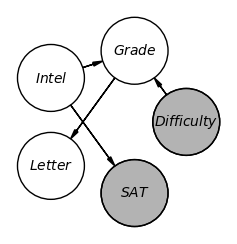

In [6]:
nodes = ["Grade"]

utils.render(model)
model.local_independencies(nodes)

### Independence (3 nodes)

**Causal / evidential / cascade / head-to-tail:** $ D \rightarrow G \rightarrow L$ implies $D \perp L | G$, but, in general, $ D \not\perp L$.

(Letter ⟂ Difficulty | Grade)
(Difficulty ⟂ Letter | Grade)

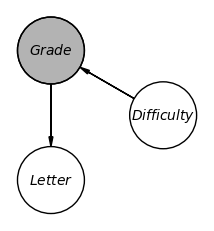

In [7]:
cascade = model.copy()
cascade.remove_nodes_from(["Intel", "SAT"])
cascade.latents = {"Difficulty", "Letter"}
utils.render(cascade)
cascade.get_independencies(include_latents=True)

### Independence (3 nodes)

**Common cause / fork / fan-out / tail-to-tail:** $ S \leftarrow I \rightarrow G$ implies $S \perp G | I$, but, in general, $ S \not\perp G$.

(SAT ⟂ Grade | Intel)
(Grade ⟂ SAT | Intel)

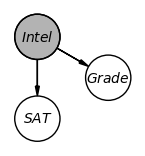

In [8]:
fork = model.copy()
fork.remove_nodes_from(["Letter", "Difficulty"])
fork.latents = {"Grade", "SAT"}
utils.render(fork)
fork.get_independencies(include_latents=True)

### Independence (3 nodes)

**Common evidence / collider / V-structure / fan-in / head-to-head:** $ I \rightarrow G \leftarrow D$ implies $I \perp D$ but, in general, $ I \not\perp D | G$.

(Intel ⟂ Difficulty)
(Difficulty ⟂ Intel)

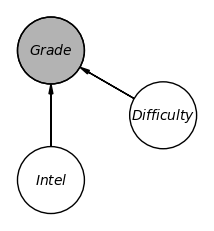

In [9]:
collider = model.copy()
collider.remove_nodes_from(["Letter", "SAT"])
collider.latents = {"Intel", "Difficulty"}
utils.render(collider)
collider.get_independencies(include_latents=True)

### Example: [Monty Hall problem](https://en.wikipedia.org/wiki/Monty_Hall_problem)

Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a car; behind the others, goats. You pick a door, say No. 0, and the host, who knows what's behind the doors, opens another door, say No. 2, which has a goat. He then says to you, "Do you want to pick door No. 1?" Is it to your advantage to switch your choice?

**Assumption:** The host must always open a door which has not been picked by the contestant and which reveals a goat.

In [10]:
node = "Host" # try "Prize"

mh_model = utils.monty_hall_model()
utils.print_cpd(mh_model.get_cpds(node))

+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| Choice  | Choice(0) | Choice(0) | Choice(0) | Choice(1) | Choice(1) | Choice(1) | Choice(2) | Choice(2) | Choice(2) |
+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| Prize   | Prize(0)  | Prize(1)  | Prize(2)  | Prize(0)  | Prize(1)  | Prize(2)  | Prize(0)  | Prize(1)  | Prize(2)  |
+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| Host(0) | 0.0       | 0.0       | 0.0       | 0.0       | 0.5       | 1.0       | 0.0       | 1.0       | 0.5       |
+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| Host(1) | 0.5       | 0.0       | 1.0       | 0.0       | 0.0       | 0.0       | 1.0       | 0.0       | 0.5       |
+---------+-----------+-----------+-----

The Bayesian model has a collider structure and, as excepted, it holds that $C \perp P$. However, in general, the door opened by the host can provide information on the location of the car, i.e.,
$$C \not\perp P | H.$$
We can infer that the posterior probability of the car being behind door 1 is the largest and thus the contestant should switch the door.

+----------+--------------+
| Prize    |   phi(Prize) |
+==========+==============+
| Prize(0) |       0.3333 |
+----------+--------------+
| Prize(1) |       0.6667 |
+----------+--------------+
| Prize(2) |       0.0000 |
+----------+--------------+


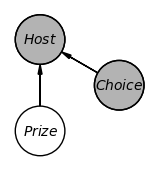

In [11]:
mh_infer = VariableElimination(mh_model)
print(mh_infer.query(["Prize"], evidence={"Choice": 0, "Host": 2}))
utils.render(mh_model)

### Independence (d-separation)

The local independencies motivate the following general theorem on conditional independencies in Bayesian models.

Let A, B, C be disjoint subsets of nodes of a DAG and consider all paths from any node in A to any node in B (treating edges as undirected). We call a path *blocked* if it includes a node $N$ such that the nodes at $N$ meet
* head-to-tail or tail-to-tail, and $N\in C$, or
* head-to-head, and $(\{N\} \cup \mathrm{De}(N)) \cap C = \emptyset $ (neither $N$ nor its descendants are in $C$).

If all paths are blocked, then A is said to be *d-separated* from B by C, and 

$$A \perp B | C.$$

A path which is not blocked is also called *active*.

d-separated: True
{'Difficulty'} ⟂ {'SAT'} | {'Intel'}


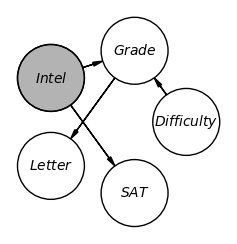

In [12]:
A = {"Difficulty"}
B = {"SAT"}
C = {"Intel"} # try {"Intel", "Letter"}, {"Letter"}, and set()

model.latents = model.nodes - C
active_trail_nodes = model.active_trail_nodes(list(A), observed=C, include_latents=True)
active_trail_nodes = set.union(*active_trail_nodes.values())
dseparated = not bool(active_trail_nodes.intersection(B))
print(f"d-separated: {dseparated}") 
if dseparated:
    print(f"{A} ⟂ {B} | {C}")
utils.render(model)

### Markov blanket

We call a subset of nodes $S$ a *Markov blanket* of node $N$, if $N$ is independent of the rest of the graph conditioned on $S$.

In a general Bayesian model, the minimal Markov Blanket (*Markov boundary*) contains all parents $\mathrm{Pa}(N)$, children $\mathrm{Ch}(N)$, and co-parents $\mathrm{CoPa}(N)$ (parents of children other than $N$), i.e.,

$$ \mathrm{Pa}(N) \cup \mathrm{Ch}(N) \cup \mathrm{CoPa}(N).$$

Markov blanket of 'Intel': {'SAT', 'Edu', 'Difficulty', 'Grade'}


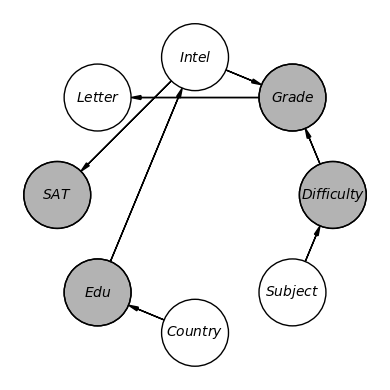

In [13]:
node = "Intel" 

ext_model = model.copy()
for tail, head in zip(["Edu", "Country", "Subject"], ["Intel", "Edu", "Difficulty"]):
    ext_model.add_edge(tail, head)
blanket = set(ext_model.get_markov_blanket(node))
print(f"Markov blanket of '{node}': {blanket}")
ext_model.latents = ext_model.nodes - blanket
utils.render(ext_model, grid_unit=3.5)

### Imperfect map

Let $C_1,C_2$ describe two independent fair coin tosses and let $B$ describe a bell which is activated if the coins show the same side. 
We observe that $C_1 \perp C_2$, $C_1 \perp B$, and $C_2 \perp B$.
This gives rise to three factorizations of the joint (and thus three Bayesian models), however none represents every (conditional) independence property of the distribution.

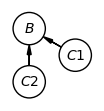

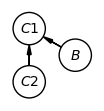

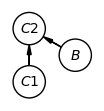

In [14]:
from pgmpy.models import BayesianNetwork

nodes = {"B", "C1", "C2"}
for head in nodes:
    utils.render(BayesianNetwork([(n, head) for n in nodes - {head}], latents=nodes))

## Markov random fields

Markov random fields are graphical models based on undirected graphs. They represent conditional independence more conveniently by graph separation (*strong Markov property*):

For any disjoint subsets $X,Y,S$ of nodes, where $S$ is a *separating set* (every path from $X$ to $Y$ passes through $S$), it holds that $X \perp Y |S$.

$\Rightarrow$ The Markov boundary of a node $N$ is just given by the set of neighbors of $N$.

Markov blanket of 'A': {'C', 'D'}


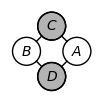

In [15]:
node = "A"
markov_model = utils.voting_model()
blanket = set(markov_model.markov_blanket(node))
print(f"Markov blanket of '{node}': {blanket}")
markov_model.latents = markov_model.nodes - blanket
utils.render(markov_model)

Note that no directed graph over four variables implies the set of conditional independence properties given by this undirected graph, i.e., 

$$A\not\perp B, \quad C \perp D | \{A , B\}, \quad A \perp B | \{C,D\}.$$

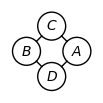

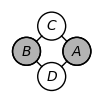

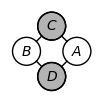

In [16]:
markov_model.latents = markov_model.nodes
utils.render(markov_model)
markov_model.latents = {"C", "D"}
utils.render(markov_model)
markov_model.latents = {"A", "B"}
utils.render(markov_model)

### Joint distribution

We cannot specify the conditional distributions as in Bayesian models. Instead we identify dependent variables and define the strength of their interactions.

We can represent such interactions by *potential functions / factors* $\phi_c$ defined on *cliques* $(N_i)_{i\in c}$ (connected subgraphs). The joint distribution is then given by

$$
p(N_1,\dots,N_K) = \frac{1}{Z} \tilde{p}(N_1,\dots,N_K) = \frac{1}{Z}\prod_{c \in \mathrm{cliques}} \phi_c\big((N_i)_{i\in c}\big),
$$

where the *partition function* (normalization constant) is given by

$$Z = \sum_{N_1,\dots,N_K} \tilde{p}(N_1,\dots,N_K).$$  

We use cliques, as our model imposes that nodes not sharing an edge are independent conditioned on the rest of the graph, i.e., they should not appear in the same factor.

For the sake of illustration, let us interpret $A,B,C,D$ in our previous example as persons. Let's assume that $\{A,C\}$, $\{C,B\}$, $\{B,D\}$, and $\{D,A\}$ are pairs of friends, which tend to have similar voting preferences. For simplicity, we assume that the preferences are the same across all pairs  and that $\phi_c =1$ for all other cliques.

In [17]:
clique_index = 0
print(markov_model.factors[clique_index])
print(markov_model.get_partition_function())

+------+------+------------+
| A    | C    |   phi(A,C) |
+======+======+============+
| A(0) | C(0) |     5.0000 |
+------+------+------------+
| A(0) | C(1) |     1.0000 |
+------+------+------------+
| A(1) | C(0) |     1.0000 |
+------+------+------------+
| A(1) | C(1) |    10.0000 |
+------+------+------------+
11327.0


For illustration, let us perform (approximate) inference on our Markov random field using [*Belief propagation / sum–product message passing*](https://en.wikipedia.org/wiki/Belief_propagation).

+------+----------+
| A    |   phi(A) |
+======+==========+
| A(0) |   0.0216 |
+------+----------+
| A(1) |   0.9784 |
+------+----------+


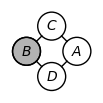

In [18]:
from pgmpy.inference import BeliefPropagation

evidence = {"B": 1} # try {"D": 1} and {"D": 1, "C": 0}

markov_model.latents = markov_model.nodes - set(evidence.keys())
voting_infer = BeliefPropagation(markov_model)
print(voting_infer.query(["A"], evidence=evidence))
utils.render(markov_model)

### Imperfect map

Finally, note that also Markov random fields do not always offer perfect maps, where every conditional independence property of a distribution
is reflected in the graph. For instance, the distribution given by a collider, $A\perp B$ and $A\not\perp B |C$, has no corresponding undirected graph (over the same variables) that is a perfect map.

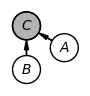

In [19]:
utils.render(BayesianNetwork([("A", "C"), ("B", "C")], latents={"A", "B"}))

### Pros & Cons

**Undirected Graphical Models / Markov Random Fields:**

$+$ can be applied to problems without directionality of the associated variable dependencies.

$+$ directly encode conditional independence structure.

$-$ expressing the joint requires to find cliques and compute the normalization constant $Z$ (often requires approximations).

$-$ interpreting undirected models and generating data is typically harder than for Bayesian models.

**Directed Graphical Models / Bayesian Networks:**

$+$ directly encode a facorization of the joint.

$-$ analyzing conditional independence requires to consider
d-separation.
